In [21]:
from os import listdir
from os.path import join
from pprint import pprint as pp
from glob import glob

import numpy as np

from scipy import misc
from scipy import ndimage

from sklearn import cluster

import pywt

from IPython.display import Image, HTML, display

from caffe_feature_extractor import get_imagenet_features

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def list_path(base):
    return [join(base, x) for x in listdir(base)]

filenames_letters = list_path('./data/letters/')
filenames_pictures = list_path('./data/pictures/')
names = filenames_letters + filenames_pictures

#pp(filenames_all)

In [ ]:
# The plan:
# 1. Scale image to 64x64
# 2. Normalize an image by scaling the maximum value of each color channel to cover the full range of intensities
# 3. Obtain Haar wavelet
# 4. Take 60 largets coeffs, quantize the rest to ±1
# 5. Use random projection to reduce 64x64x3 dimensions to 100
# 6. Add features:
#    - avg of each color channel (3 features)
#    - aspect ratio: w/(w+h)

In [5]:
names

['./data/letters/2016-01-01T17:06:49-illustratedmonthly-1152997288828311536_352141636.jpg',
 './data/letters/2016-01-01T22:34:38-draw_ul-1153162286760646225_15934020.jpg',
 './data/letters/2016-01-02T00:48:17-emmalinnea_art-1153229556651573244_291638246.jpg',
 './data/letters/2016-01-01T15:14:27-mateuszwitczakdesigns-1152940736491420170_497752429.jpg',
 './data/letters/2016-01-03T14:07:52-type.gang-1154356775748064883_1685135468.jpg',
 './data/letters/2016-01-04T12:33:02-thedailytype-1155033817724560220_36220583.jpg',
 './data/letters/2016-01-01T23:56:56-adantype-1153203712614149560_1562755458.jpg',
 './data/letters/2016-01-03T10:10:50-type.gang-1154237470364620275_1685135468.jpg',
 './data/letters/2016-01-01T04:37:00-adhex5150-1152619897569003341_31197416.jpg',
 './data/letters/2016-01-01T02:40:11-lujancarloz-1152561100791230348_177631546.jpg',
 './data/letters/2016-01-01T04:36:26-thiago_bianchini-1152619607507437701_685007145.jpg',
 './data/letters/2016-01-04T05:36:33-bhack13-1154824

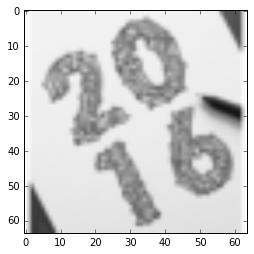

In [6]:
#print('Reading %s' % filenames_letters[0])
data = misc.imread(filenames_letters[0])
data = misc.imresize(data, (64, 64))
#data.resize(64, 64)

plt.imshow(data)
plt.show()

In [7]:
print(type(data))
print(data.shape, data.dtype)

<type 'numpy.ndarray'>
((64, 64, 3), dtype('uint8'))


In [26]:
def get_haar_features(name):
    return map(get_features, names)

def get_features(filename):
    data = misc.imread(filename)
    data = misc.imresize(data, (64, 64))
    #data.resize(64, 64)

    feature_layers = np.zeros((32, 32, 3), dtype=np.float32)
    additional = np.empty(4)
    
    for index in range(3):
        layer = data[:, :, index]
        layer = np.float32(layer)
        additional[index] = layer.mean()
        #layer /= 255.0
        #print(layer.min(), layer.max(), layer.mean())
        #print(layer[:1])

        haar = pywt.wavedec2(data=layer, wavelet='haar', level=1)
        cA = haar[0]
        feature_layers[:, :, index] = cA
        #print(len(cA))
        #print(cA.shape)
        #pp(list(cA))
        #pp(haar)

    h, w, _ = data.shape
    aspect = float(w)/(w+h)
    additional[-1] = aspect
    #print(aspect)
    #print(data[:, :, 0].mean())
    #print(feature_layers.shape)
    features = np.concatenate((feature_layers.reshape(32*32*3), additional))
    #print(features.shape)
    #features
    #feature_layers
    
    return features

In [27]:
def get_labels(names, feature_extractor=get_haar_features):
    #features = map(get_features, names)
    #features = get_imagenet_features(names)
    features = feature_extractor(names)
    #kmeans = cluster.KMeans(n_clusters=2, random_state=0)
    kmeans = cluster.KMeans(n_clusters=2)
    kmeans.fit(features)
    labels = kmeans.labels_
    return labels

labels = get_labels(names)
#zip(labels, names)
#kmeans.cluster_centers_

In [23]:
get_imagenet_features(names[:3])

[array([ 0.        ,  0.57921177,  0.21141213, ...,  0.56604099,
         1.03993249,  0.        ], dtype=float32),
 array([ 0.01669463,  0.99755955,  0.52832484, ...,  1.31598198,
         0.28433514,  1.65871346], dtype=float32),
 array([ 0.        ,  2.31613398,  0.51020658, ...,  0.24909726,
         0.47023988,  0.08781585], dtype=float32)]

In [10]:

#imagesList=''.join(
#    ["<img style='width: 64px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s)
#     for s in names])
#     for s in sorted(glob('yourimage*.png')) ])
#display(HTML(imagesList))
#display(HTML('<br>HEELLO<br>iernstierns'))

def show_clusters(names, labels):
    IMG_TEMPLATE = "<img style='width: 128px; margin: 0px; float: left; border: 1px solid black;' src='%s'/>"

    def img(name):
        return IMG_TEMPLATE % name

    for cluster in set(labels):
        display(HTML('<br>CLUSTER %s<br>' % cluster))
        items = [img(names[index]) for index in range(len(names))
                 if labels[index] == cluster]
        display(HTML(''.join(items)))
        #for index in range(len(names)):
        #    if labels[index] == cluster:
            #print(names[index])
            #pic = misc.imread(names[index])
            #plt.figure()
            #plt.imshow(pic)

In [28]:
def clusterize(names, feature_extractor=get_haar_features):
    labels = get_labels(names, feature_extractor=feature_extractor)
    show_clusters(names, labels)

In [29]:
clusterize(glob('./data/**/*.jpg'), get_haar_features)

In [30]:
clusterize(glob('./data/**/*.jpg'), get_imagenet_features)